In [ ]:
#import Library
import os
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from glob import glob

#### Culculate Synthesized Drought Index (SDI) 

In [ ]:
# List of input GeoTIFF files (VCI, TCI, PCI)
files = [
    r'D:\Project\drought\Code\vci\VCI_2024_Hasil.tif',
    r'D:\Project\drought\Code\tci\TCI_2024_Hasil.tif',
    r'D:\Project\drought\Code\pci\PCI_2024_Hasil.tif'
]

# Open all rasters and select the first band
# squeeze() removes the band dimension since each file contains only one band
data_arrays = [rxr.open_rasterio(f).squeeze() for f in files]

# Resulting shape: (variable, y, x)
stacked = xr.concat(data_arrays, dim="variable")

# Convert nodata values to NaN for easier masking
stacked = stacked.where(stacked != stacked.rio.nodata)

# Reshape spatial dimensions (y, x) into a single "pixel" dimension
flat = stacked.stack(pixel=("y", "x")).transpose("pixel", "variable")

# Create a mask to retain only pixels with valid values across all variables
valid_mask = ~np.isnan(flat).any(axis=1)
clean_data = flat.values[valid_mask]

# PCA
pca = PCA(n_components=1)
sdi_raw = pca.fit_transform(clean_data)

# Normalize PCA output to range 0–1
scaler = MinMaxScaler(feature_range=(0, 1))
sdi_clean = scaler.fit_transform(sdi_raw).flatten()

# Reshape back to original spatial dimensions (y, x)
sdi_full = np.full(flat.shape[0], np.nan, dtype=np.float32)
sdi_full[valid_mask] = sdi_clean


sdi_2d = xr.DataArray(
    sdi_full.reshape(stacked.sizes["y"], stacked.sizes["x"]),
    coords={"y": stacked.y, "x": stacked.x},
    dims=("y", "x"),
)

# Copy CRS & transform
sdi_2d.rio.write_crs(stacked.rio.crs, inplace=True)

#Save to  GeoTIFF
sdi_2d.rio.to_raster("SDI_Result_2024.tif")

print("Processing complete")

Proses selesai. File SDI_Result_2024.tif telah dibuat.


#### Stack All SDI and Visualization

In [ ]:
def stack_sdi(data_folder):
    # Search for all .tif files in the specified folder
    file_paths = glob(os.path.join(data_folder, "*.tif"))
    
    all_years = []
    
    for path in file_paths:
        # Extract year from filename (e.g., "SDI_2015.tif")
        file_name = os.path.basename(path)
        year = int(file_name.split('_')[-1].split('.')[0])

        # Open single-band raster (SDI)
        da = rxr.open_rasterio(path, masked=True).squeeze()
        
        # Assign a time coordinate
        da = da.expand_dims(
            time=[pd.to_datetime(f"{year}-01-01")]
        )
        # Rename DataArray to 'sdi'
        da.name = "sdi"
        all_years.append(da)

    # Concatenate all years along time dimension
    ds = xr.concat(all_years, dim="time").sortby("time")
    
    # Convert to Dataset (optional but cleaner for multi-year analysis)
    ds = ds.to_dataset()

    # Add metadata
    ds.attrs.update({
        'description': 'Multi-year stack of SDI for drought assessment',
        'source': 'Derived SDI (PCA-based composite index)',
        'location': 'Jeneponto, Indonesia'
    })

    # Summary output
    print(f"Successfully stacked {len(file_paths)} years of SDI data.")
    print(f"Variable: {list(ds.data_vars)}")
    print(f"Time range: {ds.time.dt.year.min().values} - {ds.time.dt.year.max().values}")
    
    return ds

In [14]:
data_folder = r"D:\Project\drought\Code\sdi"
sdi_ds = stack_sdi(data_folder)

Successfully stacked 10 years of SDI data.
Variable: ['sdi']
Time range: 2015 - 2024


<Figure size 700x400 with 0 Axes>

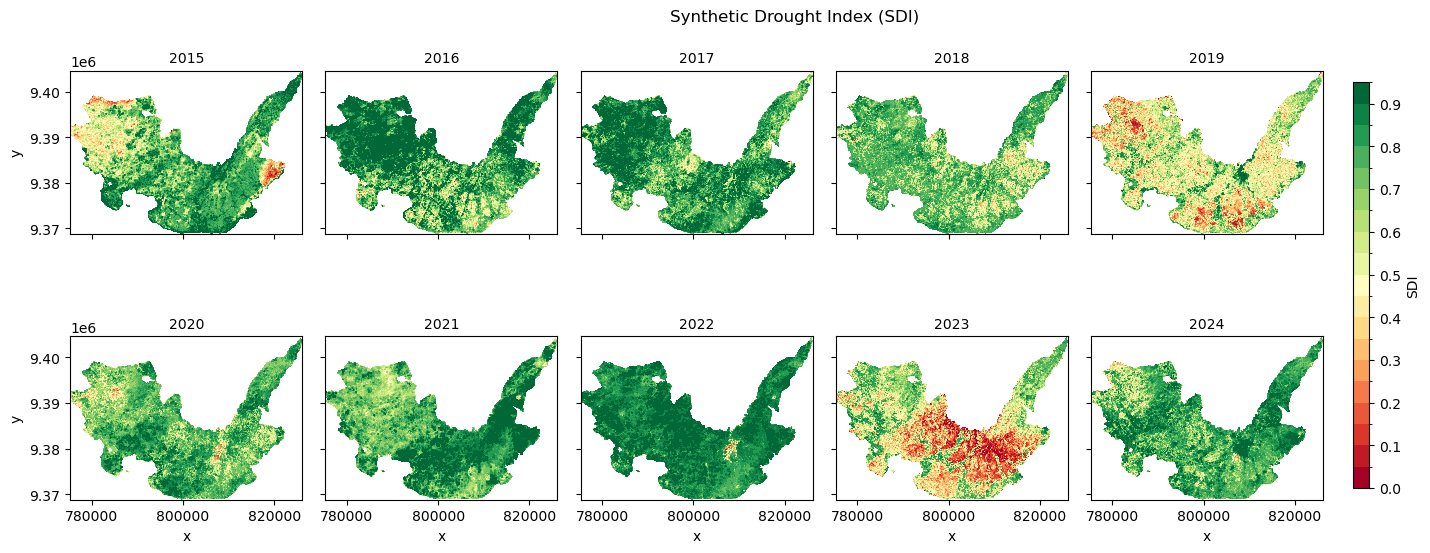

In [ ]:
# Determine the figure size at the beginning
fig = plt.figure(figsize=(7, 4)) 

vis_lst = sdi_ds.sdi.assign_coords(time=sdi_ds.time.dt.year).plot.contourf(
    x = 'x',
    y = 'y',
    col = 'time',
    col_wrap = 5,
    robust = True,
    cmap = 'RdYlGn', #revresed
    vmin = 0,
    vmax = 1,
    levels = 20,
    add_colorbar = True,
    cbar_kwargs = {"shrink": 0.8, 
                   "aspect": 25, 
                   "label": "SDI",
                   "format": "%.1f"} 
)

for ax in vis_lst.axs.flat:
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

# space settings
vis_lst.fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.83)
vis_lst.set_titles("{value}")

plt.suptitle('Synthetic Drought Index (SDI)', y=0.98)
plt.show()